Sentinel-1 SAR wind products are available here: http://thredds.nersc.no/thredds/catalog/sarvind/SarVind/2019/catalog.html.

External datasets that need to be downloaded:

- https://oceancolor.gsfc.nasa.gov/docs/distfromcoast/

Validation datasets:

- land stations (only use the ones closer than 1 km from the coast)
  - https://thredds.met.no/thredds/catalog/met.no/observations/stations/catalog.html
- wind buoys
  - https://thredds.met.no/thredds/catalog/obs/buoy-svv-e39/catalog.html
  - https://thredds.met.no/thredds/catalog/obs/kystverketbuoy/catalog.html

In [1]:
import os, sys
import django
django.setup()

from django.conf import settings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nansat.nansat import Nansat
from nansat.domain import Domain
from nansat.tools import haversine
from openwind import sar_wind
from geospaas_wind.utils import wind_from_sar_and_arome_forecast

In [3]:
#fn = 'http://thredds.nersc.no/thredds/dodsC/sarvind/SarVind/2019/08/21/WIND_S1B_IW_GRDM_1SDV_20190821T155906_20190821T155939_017686_021461_7D4D.nc'
fn = 'http://thredds.nersc.no/thredds/dodsC/sarvind/SarVind/2019/09/11/WIND_S1B_IW_GRDM_1SDV_20190911T153510_20190911T153537_017992_021DF1_5C9D.nc'

In [4]:
n = Nansat(fn)

/home/vagrant/Miniconda3-4.5.1-Linux-x86_64/envs/py3openwind/lib/python3.6/site-packages/nansat/mappers/opendap.py:112: UserWarning: Time consuming loading time from OpenDAP...
  warnings.warn('Time consuming loading time from OpenDAP...')
/home/vagrant/Miniconda3-4.5.1-Linux-x86_64/envs/py3openwind/lib/python3.6/site-packages/nansat/mappers/opendap.py:114: UserWarning: Loading time - OK!
  warnings.warn('Loading time - OK!')


In [6]:
lon, lat = n.get_geolocation_grids()

In [7]:
u = n['U']
v = n['V']

In [7]:
%matplotlib inline
import cartopy.feature as cfeature
from cartopy import config
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

Text(0.5, 1.05, 'Meridional wind speed')

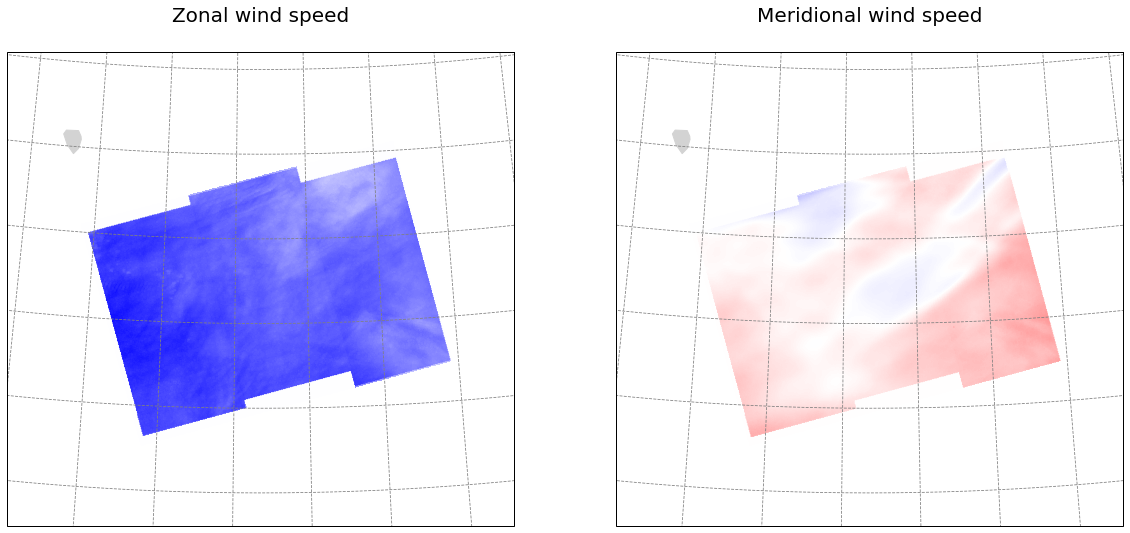

In [8]:
globe = ccrs.Globe(ellipse='WGS84', semimajor_axis=6378137, flattening=1/298.2572235604902)
proj = ccrs.Stereographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat), globe=globe)
#proj = ccrs.Stereographic(central_longitude=15, central_latitude=80, globe=globe)

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': proj}, figsize=(20, 20))
extent = [np.min(lon)-.5, np.max(lon)+.5, np.min(lat)-.5, np.max(lat)+.5]
land_f = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray')

axs[0].set_extent(extent, crs=ccrs.PlateCarree())
axs[0].gridlines(color='gray', linestyle='--')
axs[0].add_feature(land_f)
#axs[0].coastlines(resolution='10m')
axs[0].contourf(lon, lat, u, 200, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='bwr')
axs[0].set_title('Zonal wind speed', y=1.05, fontsize=20)

axs[1].set_extent(extent, crs=ccrs.PlateCarree())
axs[1].gridlines(color='gray', linestyle='--')
axs[1].add_feature(land_f)
#axs[1].coastlines(resolution='10m')
axs[1].contourf(lon, lat, v, 200, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='bwr')
axs[1].set_title('Meridional wind speed', y=1.05, fontsize=20)

Find overlapping MET stations

In [5]:
from geospaas.catalog.models import Dataset
sar_wind = Dataset.objects.filter(dataseturi__uri__contains='WIND_S1')
coll_dict = {}
for ds in sar_wind:
    coll_dict[ds.pk] = {}
    # Find overlapping met stations (check for wind speed parameter)
    coll_dict[ds.pk]['metno_obs_stations'] = Dataset.objects.filter(
                                    source__platform__short_name='METEOROLOGICAL STATIONS',
                                    time_coverage_start__lt=ds.time_coverage_start,
                                    geographic_location__geometry__intersects=ds.geographic_location.geometry)
    # Find overlapping met wind buoys (check for wind speed parameter)
    coll_dict[ds.pk]['buoys'] = Dataset.objects.filter(
                                    dataseturi__uri__contains='buoy_svv', 
                                    time_coverage_start__lt=ds.time_coverage_start, 
                                    time_coverage_end__gt=ds.time_coverage_end, 
                                    geographic_location__geometry__intersects=ds.geographic_location.geometry)        

In [6]:
coll_dict

{1073: {'metno_obs_stations': <QuerySet [<Dataset: METEOROLOGICAL STATIONS//1956-09-01T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//1910-01-01T00:00:00+00:00>]>,
  'buoys': <QuerySet []>},
 1072: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 1071: {'metno_obs_stations': <QuerySet [<Dataset: METEOROLOGICAL STATIONS//1500-01-01T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//2011-01-01T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//2011-01-26T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//1984-01-01T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//1500-01-01T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//2003-12-04T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//1933-09-11T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//2015-09-09T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//2013-10-07T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//1971-01-01T00:00:00+00:00>, <Dataset: METEOROLOGICAL STATIONS//2010-07-16T00:00:00+00:00>, 

In [15]:
pk = 2291
sar_wind0 = Dataset.objects.get(pk=pk)
met_station = coll_dict[pk]['metno_obs_stations'][0]

In [16]:
met_station

<Dataset: METEOROLOGICAL STATIONS//1910-08-28T18:00:00+00:00>

In [17]:
import netCDF4
nc_met_station = netCDF4.Dataset(met_station.dataseturi_set.get().uri)

In [18]:
nc_met_station

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    DODS.strlen: 7
    DODS.dimName: station_id
    DODS_EXTRA.Unlimited_Dimension: time
    dimensions(sizes): time(325100), maxStrlen64(64)
    variables(dimensions): float64 time(time), float64 latitude(), float64 longitude(), |S1 station_id(maxStrlen64), float32 air_temperature_2m(time), float32 wind_speed_10m(time), float32 surface_air_pressure_2m(time), float32 wind_from_direction_10m(time), float32 relative_humidity(time), float32 air_pressure_at_sea_level(time), float32 air_pressure_at_sea_level_qnh(time), float32 mean_surface_downwelling_shortwave_flux_in_air_PT1H(time), float32 mean_surface_downwelling_longwave_flux_in_air_PT1H(time)
    groups: 

In [19]:
import datetime
from dateutil.parser import parse
reftime = parse(nc_met_station.variables['time'].units.split()[2])
dt = sar_wind0.time_coverage_start.replace(tzinfo=None) - reftime
ind = np.argmin(np.abs(dt.total_seconds()-nc_met_station.variables['time'][:].data))

In [20]:
parse(nc_met_station.variables['time'].units.split()[2]) + \
    datetime.timedelta(seconds=nc_met_station.variables['time'][:].data[ind])

datetime.datetime(2019, 8, 27, 5, 50)

In [21]:
sar_wind0.time_coverage_start

datetime.datetime(2019, 8, 27, 5, 26, 52, 133869, tzinfo=<UTC>)

In [22]:
nc_met_station.variables['wind_speed_10m']

<class 'netCDF4._netCDF4.Variable'>
float32 wind_speed_10m(time)
    long_name: Mean wind speed
    coverage_content_type: coordinate
    standard_name: wind_speed
    units: m s-1
    _ChunkSizes: 1024
unlimited dimensions: time
current shape = (325100,)
filling off

In [23]:
nc_met_station.variables['wind_speed_10m'][:].data[ind]

9.96921e+36